In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.base import clone


with open('../../data/DatasetCleaned.csv', 'r') as f:
    DATA = pd.read_csv(f)


Y_DATA = np.log(DATA['SalePrice'].copy()).values
VAR_DEPENDENT = 'SalePrice_log'

X_DATA = DATA.copy().drop(columns=['SalePrice','Unnamed: 0'])


def PrepX(X:pd.DataFrame, scaler_type=PowerTransformer(method='yeo-johnson'), 
          only_dummies:bool=False, fit:bool=False):

    X_prep = pd.DataFrame(index=X.index)
    X_types = X.dtypes.to_dict()

    #Stores Scalers later in Dictionary (Column:Scaler)
    if fit: scalers = {}
    else: scalers = scaler_type

    new_cols = []

    #Iterates over X and applies transformations based on column type; Adds transformed columns 
    for col, t in X_types.items():

        #Dummy columns and Percentages that don't need to be scaled (computed in Preperation.ipynb)
        if t != 'object' and -1 <= X[col].min() and X[col].max() <= 1 and not only_dummies: 
            new_cols.append(X[col].copy().replace({-1:0})) 
            continue

        #Transforms Numeric values; either builds scalers or applies them
        if t in ['int', 'float'] and not only_dummies:
            nonapplicable = X[col] == -1

            new_col = X[col].copy()
            applic_values = new_col.loc[~nonapplicable].values.reshape(-1, 1)

            #If fit=True, construct a new scaler for the training data. Otherwise, use the SCALER dict to scale test data
            if fit: 
                scaler = clone(scaler_type)
                scaler.fit(applic_values)
                scalers[col] = scaler
                new_col.loc[~nonapplicable] = scaler.transform(applic_values).flatten()
            else:
                new_col.loc[~nonapplicable] = scalers[col].transform(applic_values).flatten()


            new_col.loc[nonapplicable] = 0

            new_cols.append(new_col)
            
            continue

        #Create dummies for categorical (str) columns; with Validation set this is done before splitting
        if t == 'object': 
            new_col = pd.get_dummies(X[col].copy(), prefix=col, drop_first=True, dtype=int)
            new_cols.append(new_col)
            continue

        #This is only relevant when creating only dummies for the validation Set to not loose columns
        if only_dummies and t != 'object':
            X_prep[col] = X[col].copy()
        else:
            print(f'Type \"{t}\" not in standard types!')

    if new_cols: X_prep = pd.concat([X_prep] + new_cols, axis=1)

    if fit: return X_prep, scalers
    else: return X_prep

#Split data into train and validation set. 
# #train_test_split is not because before splitting we need to ensure that all dummy variables are present to not have missing columns in either set
def Split(X:pd.DataFrame, Y:pd.DataFrame, TestSize:float, random_state:int=42):

    X = PrepX(X_DATA, only_dummies=True, fit=False)

    split_index = np.random.RandomState(random_state) \
                           .choice([True, False], size=len(Y), p=[TestSize,1-TestSize])
    
    X_test = X[split_index]
    X_train = X[~split_index]
    Y_test = Y[split_index]
    Y_train = Y[~split_index]

    return X_test, X_train, Y_test, Y_train


VALIDATION_SET = True
if VALIDATION_SET: 
    X_VAL, X_DATA, Y_VAL, Y_DATA = Split(X_DATA, Y_DATA, 0.05, 1)

X_DATA, SCALER = PrepX(X=X_DATA, fit=True)
VAR_NAMES = X_DATA.columns
X_DATA = X_DATA.values.reshape(-1,X_DATA.shape[1])

if VALIDATION_SET:
    X_VAL = PrepX(X=X_VAL, scaler_type=SCALER)
    X_VAL = X_VAL.values.reshape(-1, X_VAL.shape[1])

C:\Users\karli\AppData\Local\Temp\ipykernel_66392\89680385.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.14545181  0.09841449  0.40342175 ... -1.70419946  3.88329402
 -0.37218074]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_col.loc[~nonapplicable] = scaler.transform(applic_values).flatten()
C:\Users\karli\AppData\Local\Temp\ipykernel_66392\89680385.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.677626   -0.03607174  0.677626   ... -0.03607174  2.67851644
 -0.78029271]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_col.loc[~nonapplicable] = scaler.transform(applic_values).flatten()
C:\Users\karli\AppData\Local\Temp\ipykernel_66392\89680385.py:49: FutureWarning: Setting an item of incompatible dtype is deprec

In [11]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

def BootstrapLasso(Y, X, feature_names:list, alpha, n_bootstrap, oob:bool=True, save_bootstrap_sample:bool=False):

    n_obs = len(Y)

    B = []
    FailedReg = 0
    for i in tqdm(range(0, n_bootstrap),
                  desc='Fitting Lasso-Model with Bootstrapped Samples', unit='sample'):
        sample_index = np.random.choice(range(0, n_obs), size=n_obs, replace=True)

        X_sample = X[sample_index]
        Y_sample = Y[sample_index]

        lasso = LassoCV(alphas=alpha, cv=KFold(), max_iter=100000, n_jobs=-1)
        lasso.fit(X_sample, Y_sample)        

        if lasso.alpha_ == min(alpha) or lasso.alpha_ == max(alpha): 
            FailedReg += 1
            continue

        coefs = {}
        for i, var in enumerate(feature_names):
            coefs[var] = lasso.coef_[i]

        if oob:
            oob_index = np.setdiff1d(np.arange(n_obs), sample_index)
            X_test = X[oob_index]
            Y_test = Y[oob_index]
        else:
            X_test = X
            Y_test = Y

        rsme = root_mean_squared_error(np.exp(Y_test), np.exp(lasso.predict(X_test)))

        if save_bootstrap_sample:
            B.append({
                'X_sample':X_sample,
                'Y_sample':Y_sample,
                'Sample_Key':sample_index,
                'LassoModel':lasso,
                'alpha':lasso.alpha_,
                'r_squared':lasso.score(X_sample, Y_sample),
                'r_squared_fullData':lasso.score(X, Y),
                'coefficients':coefs,
                'mse':rsme,
                'N Nonzero Estimators':sum([1 for key, item in coefs.items() if item != 0])
            })
        else:
            B.append({
                'Sample_Key':sample_index,
                'LassoModel':lasso,
                'alpha':lasso.alpha_,
                'r_squared':lasso.score(X_sample, Y_sample),
                'r_squared_fullData':lasso.score(X, Y),
                'coefficients':coefs,
                'mse':rsme,
                'N Nonzero Estimators':sum([1 for key, item in coefs.items() if item != 0])
            })


    print(f'{FailedReg} failed regularizations')
    return pd.DataFrame(B)

In [1]:
import pickle

with open('models/Bootstrapping.sav', 'rb') as f: BootstrappedModels = pickle.load(f)
with open('models/Lasso.sav', 'rb') as f: Original_LASSO = pickle.load(f)
LassoOrig = Original_LASSO['Model']
ScalerOrig = Original_LASSO['Scaler']

#This takes about 30 Minutes to run
#BootstrappedModels = BootstrapLasso(Y_DATA, X_DATA, VAR_NAMES, alpha=np.logspace(-4,-2,200), n_bootstrap=1000)
#with open('models/Bootstrapping.sav', 'wb') as f: pickle.dump(BootstrappedModels, f)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def Coefficient_Boxplots(B_Coefficients:pd.Series, Lasso_Orig:LassoCV, var_names:list, cutoff:int=0.0):

    relevant_cols = []
    for i, var in enumerate(var_names):
        values = np.array([B[var] for B in B_Coefficients])
        if np.count_nonzero(values) / len(values) >= cutoff:
            relevant_cols.append({'var':var, 'coefs':values, 'index':i})
    
    boxplot_rows = int(np.ceil(len(relevant_cols) / 5))
    fig, axes = plt.subplots(boxplot_rows, 5, figsize=(15, 2*boxplot_rows))
    axes = axes.flatten()

    for ax, var in zip(axes, relevant_cols):
        ax.boxplot(var['coefs'], patch_artist=True)
        ax.axhline(y = 0, color='black', ls = '--')
        ax.axhline(y = Lasso_Orig.coef_[var['index']], color = 'red', ls=':')
        ax.set_title(var['var'], fontsize=8)

    plt.show()


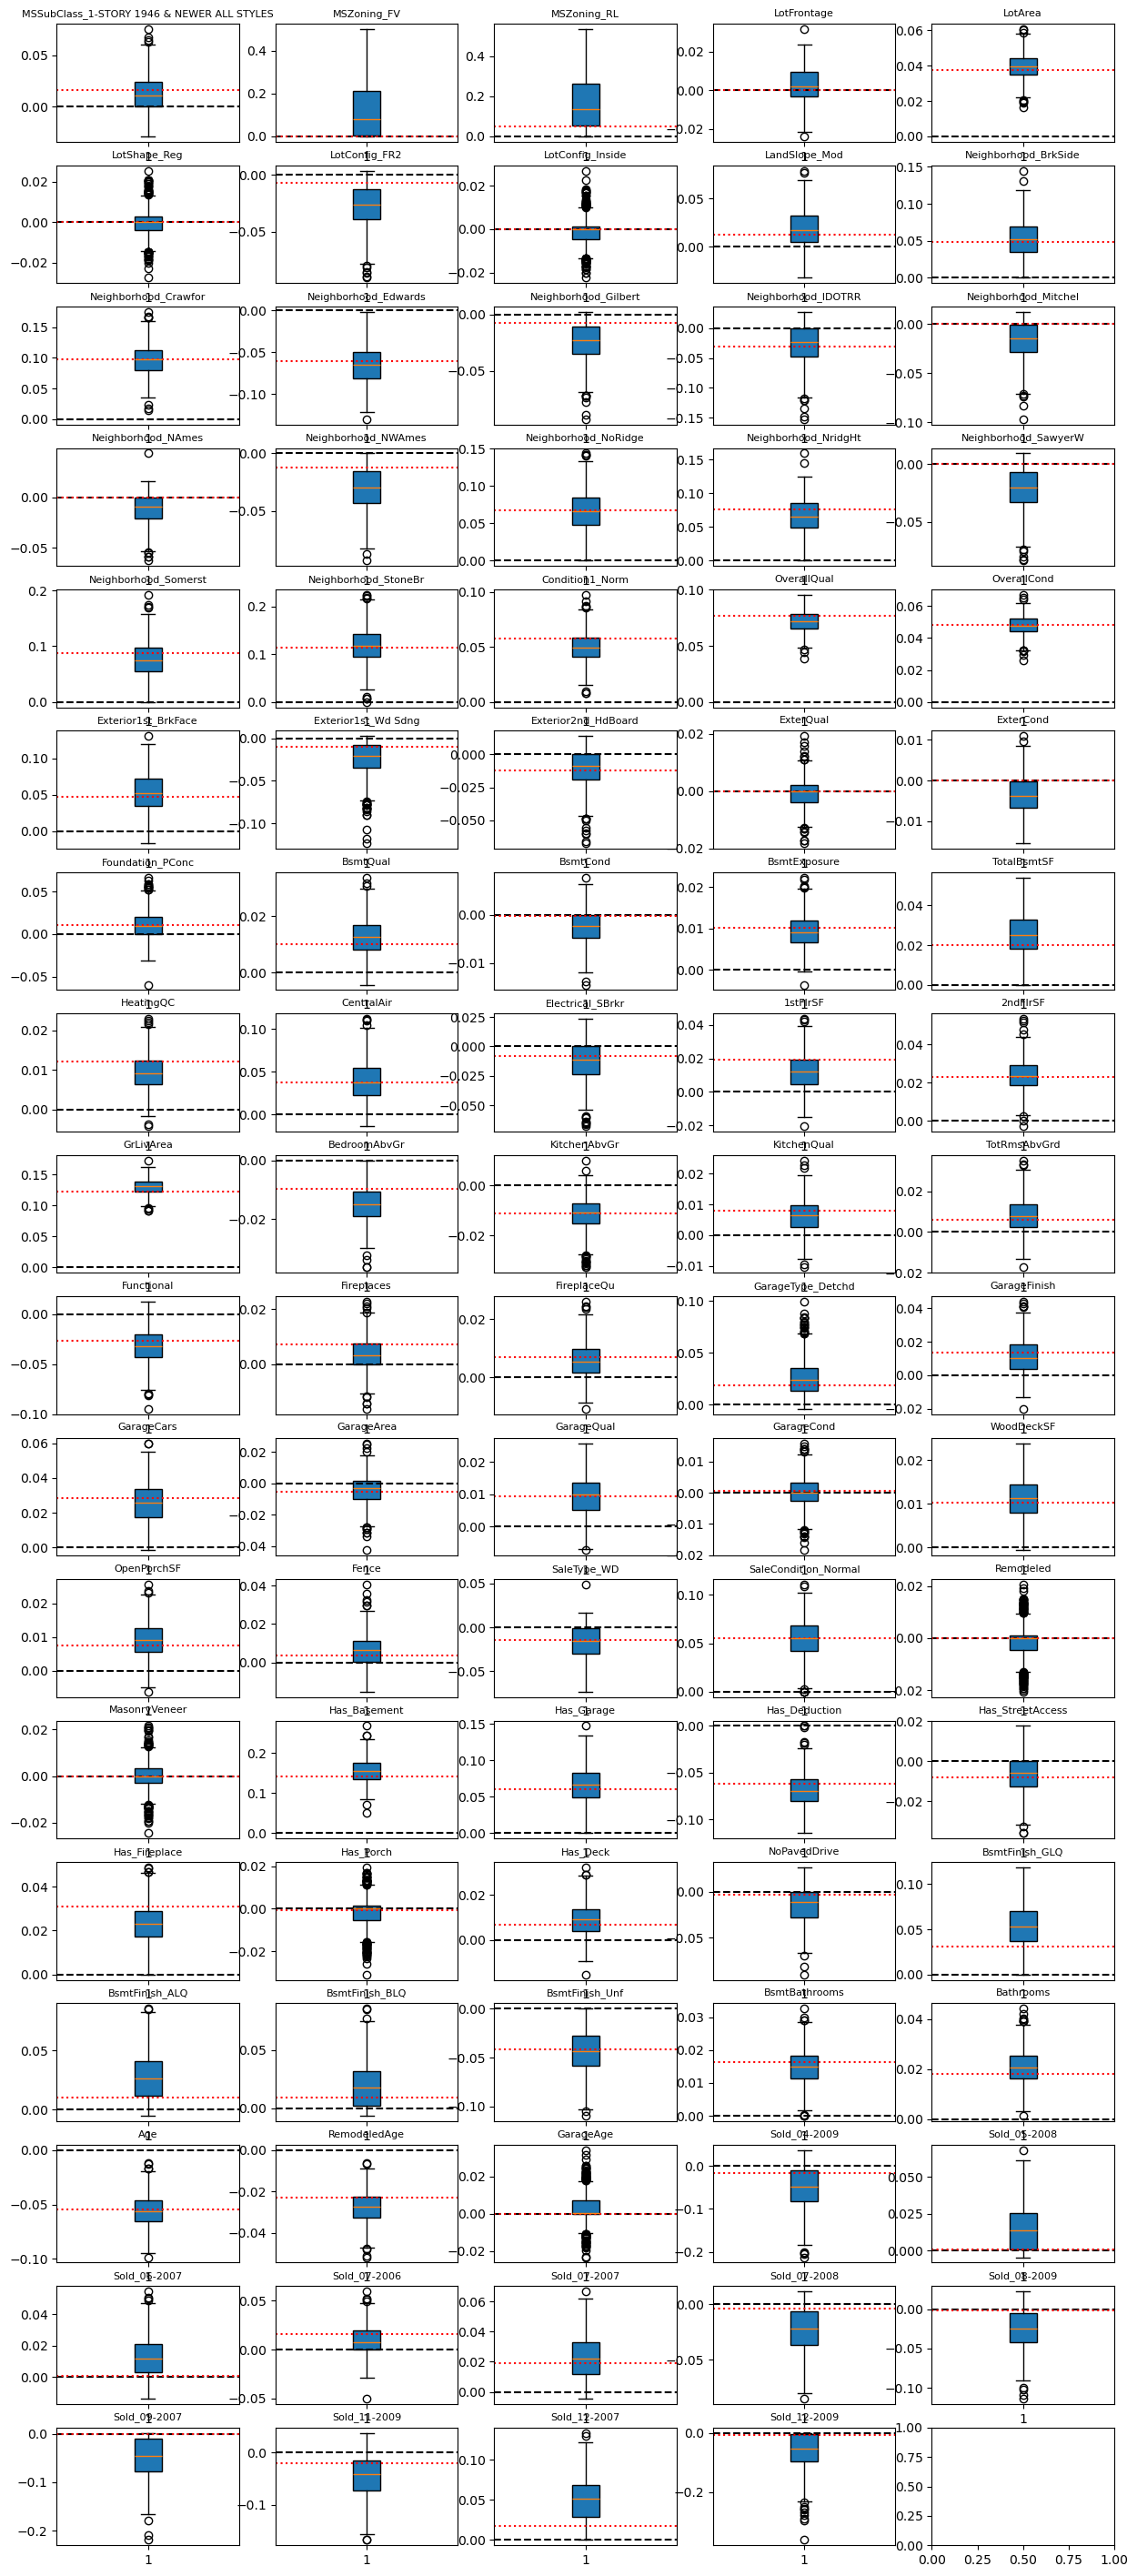

In [24]:
Coefficient_Boxplots(BootstrappedModels['coefficients'], LassoOrig, VAR_NAMES, 0.75)

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
import xgboost as xgb

#Class for saving the top_models and using them later to transform X data before using the stacked model
class StackedTransformer:
    def __init__(self, top_models):
        self.top_models = top_models

    def __call__(self, X_new):

        y_pred = pd.DataFrame(np.column_stack([model.predict(X_new) for model in self.top_models]), 
                              columns=[f'Model_{i}' for i in range(len(self.top_models))])

        return y_pred


def Build_Stacked_Model(X, Y, bootstrapped_lasso:pd.DataFrame, n_top, alphas):

    #Extract top_fraction% of best performing parameters
    top_samples = bootstrapped_lasso.sort_values(by='mse').reset_index(drop=True)
    top_samples = top_samples.iloc[:int(n_top)]

    #Fit best models
    top_models = [b_model['LassoModel'] for _, b_model in top_samples.iterrows()]

    #Calculating predicted Values for each model
    y_pred_list = []
    for model in top_models:
        y_pred_list.append(model.predict(X))
    y_predicted = pd.DataFrame(
        np.column_stack( y_pred_list ),
        columns=[f'Model_{i}' for i in range(len(top_models))]
    )

    Stacked_Model = RidgeCV(alphas=alphas, cv=KFold(), scoring='neg_root_mean_squared_error')
    Stacked_Model.fit(y_predicted, Y_DATA)

    #Define Function-Class to use Meta model later; before prediction, an X must be transformed
    XPrepFunction = StackedTransformer(top_models)

    return Stacked_Model, XPrepFunction


In [54]:
BLassoStack, BLassoStack_PrepX = Build_Stacked_Model(X_DATA, Y_DATA, BootstrappedModels, len(BootstrappedModels), np.logspace(2,3,200))

In [56]:
from sklearn.metrics import root_mean_squared_error

print(f'Original Lasso Model: {root_mean_squared_error(np.exp(Y_VAL), np.exp(LassoOrig.predict(X_VAL)))}')
print(f'Stacked Bootstrapped Model: {root_mean_squared_error(np.exp(Y_VAL), np.exp(BLassoStack.predict(BLassoStack_PrepX(X_VAL))))}')

Original Lasso Model: 17743.10574027774
Stacked Bootstrapped Model: 18429.47286890206


In [57]:
import pickle

with open('models/BootstrappedLASSO.sav', 'wb') as f: 
    pickle.dump({'StackedModel':BLassoStack,'XPrepFunction':BLassoStack_PrepX} ,f)